# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [8]:
# Load from toy dataloader with two sessions
if sys.platform == 'linux':
    # data_path = '/home/qix/user_data/allen_spike_trains/single_sessions.joblib'
    # data_path = '/home/qix/user_data/allen_spike_trains/two_sessions.joblib'
    # data_path = '/home/qix/user_data/allen_spike_trains/five_sessions.joblib'
    data_path = '/home/qix/user_data/allen_spike_trains/ten_sessions.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/two_sessions.joblib'
two_sessions_dataloader = joblib.load(data_path)

# Train a model

Things I want to try:
- with all parameters not frozen (running now). See how it compares to the model with readout matrix frozen (0.0642). **Yes, it's a tiny bit better 1e-4.**
- Use more factors for the stimulus effect. **Yes, it improves 0.064 -> 0.063.**
- Increase the number of B-spline basis to see if it capture shift in peaks. **Yes, it improves 1e-4, but makes the function more oscillatory.**
- Use inhomogeneous baseline + var as the trial-wise stimulus effect. So the VAE only needs to learn the difference across trials.
- Compare the three steps (0.06365) training with directly training with the last step (0.06378). **Yes, it's better 2e-4.**


In [9]:
LOAD_A_MODEL = True
FIT_THE_BASELINE_MODEL = False
model_path = "".join([
    '/home/qix/user_data/VAETransformer_checkpoint_hp_tuning/',
    'ghidorah2_[757216464, 798911424, 715093703, 719161530, 721123822, 737581020, 739448407, 742951821, 743475441, 744228101]_20250511_225549',
    '.pth'
])

# data_to_use = cross_session_dataloader
data_to_use = two_sessions_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

params = {
    # B-spline basis
    'num_B_spline_basis': 30,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 24,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 1.5,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': 1e-4,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 50,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if LOAD_A_MODEL:
    trainer.load_model_and_hp(filename=model_path)
else:
    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
            record_results=True,
        )



Total sessions: 10, Batch size: 64, Train set size: 1326, Val set size: 201, Test set size: 392


/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Trainer instance (model and hyperparameters) loaded from /home/qix/user_data/VAETransformer_checkpoint_hp_tuning/ghidorah2_[757216464, 798911424, 715093703, 719161530, 721123822, 737581020, 739448407, 742951821, 743475441, 744228101]_20250511_225549.pth


/home/qix/FC-GPFA/model_trainer.py:459: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=map_location)
/home/qix/anaconda3/envs/a

**Remember to change "include_self_history"**

In [111]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            include_self_history=False,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")
trainer.save_model_and_hp(filename=None, test_loss=test_loss)

  0%|          | 0/392 [00:00<?, ?it/s]

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
 40%|████      | 158/392 [01:15<00:53,  4.37it/s]/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
 50%|█████     | 197/392 [01:30<00:59,  3.25it/s]/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserW

Test loss: 0.05890564707074629
Test loss baseline: 0.06841092058005825
Trainer instance (model and hyperparameters) saved to /home/qix/user_data/VAETransformer_checkpoint/ghidorah3_[757216464, 798911424, 715093703, 719161530, 721123822, 737581020, 739448407, 742951821, 743475441, 744228101]_20250512_161434.pth


In [10]:
def get_batch_of_test_drifting_grating(trainer, session_i=0):
    session_id = trainer.dataloader.session_ids[session_i]

    table = trainer.dataloader.sessions[session_id].presentation_table
    drifting_grating_trial_ids = table[table['stimulus_name'] == 'drifting_gratings'].index
    drifting_grating_trial_ids += trainer.dataloader.session_trial_indices[0][0]

    # Get the test trial indices for the first session (757216464)
    session_start = trainer.dataloader.session_trial_indices[session_i][0]
    session_end = trainer.dataloader.session_trial_indices[session_i][1]

    # Filter test batches to only include trials from first session
    session_test_trials = []
    for batch in trainer.dataloader.test_batches:
        # Only include trials that fall within first session range
        session_trials = batch[(batch >= session_start) & (batch < session_end)]
        if len(session_trials) > 0:
            session_test_trials.extend(session_trials)

    # Get intersection of drifting grating trials and test trials
    test_drifting_grating_trials = list(set(drifting_grating_trial_ids).intersection(session_test_trials))
    test_drifting_grating_trials.sort()
    batch = trainer.dataloader._load_batch(np.array(test_drifting_grating_trials))

    

    return batch

batch = get_batch_of_test_drifting_grating(trainer, session_i=0)
batch['spike_trains'].shape


/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


torch.Size([250, 352, 166])

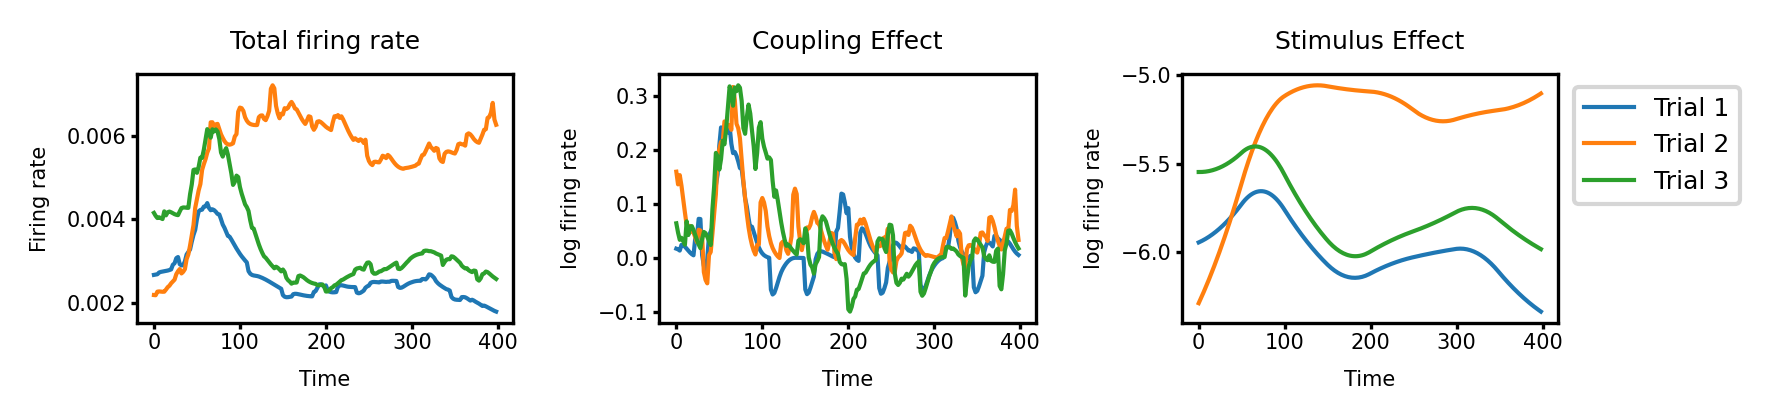

In [14]:
plot_session = str(757216464)
trial_indices = np.random.choice(np.arange(0, 166), 3)
plot_area = 3
utils.use_pdf_plot()

firing_rate_test, sti_mu_test, sti_logvar_test, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=False,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=False,
    return_spike_trains=True,
)

trainer.model.get_inhomo_firing_rates_stimulus()
inhomo_factor = trainer.model.factors[None,:,:,:]

firing_rate_test, sti_mu_test, sti_logvar_test, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    manual_batches=[batch],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=False,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=False,
    return_spike_trains=True,
)

neuron_start = trainer.model.accnneuron_dict[plot_session][plot_area]
neuron_end = trainer.model.accnneuron_dict[plot_session][plot_area+1]
neuron_idx = torch.argsort(spike_train_test[:, neuron_start:neuron_end, :].mean(dim=(0,2)))[0]

# Create a 2x2 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(6, 1.5) ,dpi=300)
# fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
xx = np.arange(0, 400, 2)
axes[0].plot(xx, np.exp(firing_rate_test[:, neuron_start:neuron_end, trial_indices].mean(dim=1).numpy()))
# axes[0].plot(xx, firing_rate_test[:, neuron_idx, trial_indices].numpy())
axes[0].set_title('Total firing rate')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Firing rate')


# Plot coupling effect
axes[1].plot(xx, trainer.model.firing_rates_coupling[trial_indices, neuron_start:neuron_end, :].mean(dim=1).cpu().numpy().T)
axes[1].set_title('Coupling Effect')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('log firing rate')

# Plot stimulus effect
axes[2].plot(xx, trainer.model.firing_rates_stimulus[trial_indices, neuron_start:neuron_end, :].mean(dim=1).cpu().numpy().T)
axes[2].set_title('Stimulus Effect')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('log firing rate')
axes[2].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
                 bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# # Plot t-SNE in the last subplot
# sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
# if np.all(sti_mu_test_np.std(axis=0) > 1e-3):
#     tsne = TSNE(n_components=2, random_state=42)
#     sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
#     axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
#     axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
#     axes[1,1].set_xlabel('t-SNE 1')
#     axes[1,1].set_ylabel('t-SNE 2')
# else:
#     print(f"Stimulus latent is not varying across trials: {sti_mu_test_np.std(axis=0).mean()}")

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)

In [15]:
### Find cross-pop neurons in the local neurons
select_probe_list = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
import pickle
with open('group_id_all_a_c/membership.pickle', 'rb') as handle:
    membership = pickle.load(handle)
with open('group_id_all_a_c/condition_ids.pickle', 'rb') as handle:
    condition_ids = pickle.load(handle)
cross_pop_neuron_ids_list = []
cross_pop_neuron_local_idx_list = []
for i_area, select_probe in enumerate(select_probe_list):
    cross_pop_neuron_ids_list.append(membership[0][
        (membership[0]['probe'] == select_probe) & 
        (membership[0]['group_id'] == 0)
    ].index.values)
    neuron_start = trainer.model.accnneuron_dict[plot_session][i_area]
    neuron_end = trainer.model.accnneuron_dict[plot_session][i_area+1]
    local_neuron_ids = batch['neuron_id'][neuron_start:neuron_end]
    cross_pop_neuron_local_idx = np.where(np.isin(local_neuron_ids, cross_pop_neuron_ids_list[i_area]))[0]
    cross_pop_neuron_local_idx_list.append(cross_pop_neuron_local_idx)

In [17]:
trainer.dataloader.sessions[757216464].get_running()
trainer.dataloader.sessions[757216464].get_pupil_diam()
running_or_stationary = trainer.dataloader.sessions[757216464].running_trial_index[batch['presentation_ids']]
pupil_diams = trainer.dataloader.sessions[757216464].mean_pupil_diam[batch['presentation_ids']]

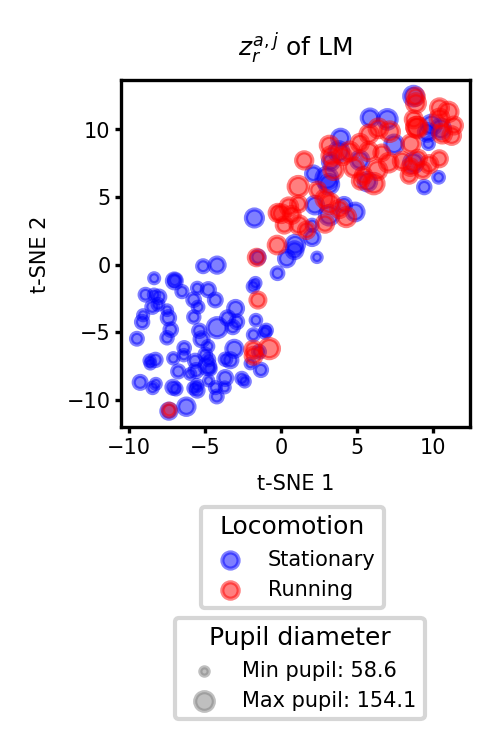

In [61]:
# Plot t-SNE colored by running state and sized by pupil diameter
from sklearn.manifold import TSNE

sti_mu_test_np = sti_mu_test.detach().cpu().numpy()[:, 4*3:4*4] if torch.is_tensor(sti_mu_test) else sti_mu_test

if np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    
    # Normalize pupil diameters for scatter plot sizes
    min_size = 20
    max_size = 100
    normalized_sizes = min_size + (max_size-min_size)*(pupil_diams - pupil_diams.min())/(pupil_diams.max() - pupil_diams.min())
    
    # Compute t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    
    # Create scatter plot with running/stationary colors and pupil diameter sizes
    utils.use_pdf_plot()
    plt.figure(figsize=(1.5, 1.5), dpi=300)
    plt.scatter(sti_mu_test_tsne[~running_or_stationary, 0], 
                sti_mu_test_tsne[~running_or_stationary, 1],
                s=normalized_sizes[~running_or_stationary],
                c='blue', alpha=0.5, label='Stationary', marker='.')
    plt.scatter(sti_mu_test_tsne[running_or_stationary, 0],
                sti_mu_test_tsne[running_or_stationary, 1], 
                s=normalized_sizes[running_or_stationary],
                c='red', alpha=0.5, label='Running', marker='.')

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    first_legend = plt.legend(title='Locomotion', loc='upper left', title_fontsize=6, bbox_to_anchor=(0.2, -0.2))
    plt.gca().add_artist(first_legend)
    # Add legend for pupil diameter sizes
    legend_elements = [
        plt.scatter([], [], c='gray', alpha=0.5, s=min_size/5, label=f'Min pupil: {pupil_diams.min():.1f}'),
        plt.scatter([], [], c='gray', alpha=0.5, s=max_size/5, label=f'Max pupil: {pupil_diams.max():.1f}')
    ]
    
    # Create a second legend below the first one

    # Add empty line between legend entries
    plt.legend(handles=legend_elements, loc='upper right', title='Pupil diameter',
               title_fontsize=6, bbox_to_anchor=(0.9, -0.52))
    plt.title('$z_{r}^{a,j}$ of LM')
else:
    print(f"Stimulus latent is not varying across trials: {sti_mu_test_np.std(axis=0).mean()}")

plt.savefig('Figure/Figure5_tsne.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_2235470/2734399438.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


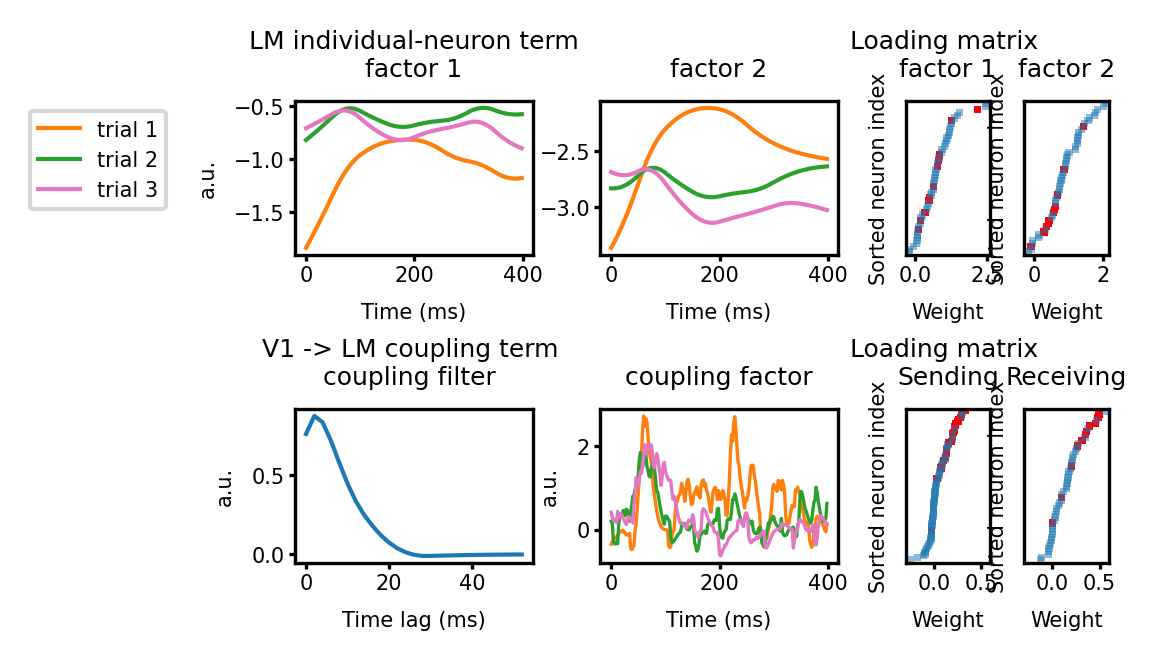

In [69]:
plot_session = str(757216464)
plot_area = 3
coupling_from = 2

# Pick a trial with intermediate fit (using middle trial)
local_trial_indices = utils.find_middle_fit_trial(
    firing_rate_test, 
    spike_train_test,
    left_and_right_trials=1,
)
# local_trial_idx = np.random.choice(np.arange(0, 166), 3)
colors = ['tab:orange', 'tab:green', 'tab:pink']


# Create 2x3 subplot
utils.use_pdf_plot()
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(3.5, 2.0), dpi=300)
outer = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=1, width_ratios=[0.35, 0.35, 0.3])
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        if (i, j) not in [(0, 2), (1, 2)]:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])


# global_trial_idx = trial_indices[local_trial_idx]
xx = np.arange(firing_rate_test.shape[0])*2

### First row - Baseline components
# Normalize both the ground truth and the fitted
readout_mat_fitted = trainer.model.sti_readout_matrix_dict[plot_session][plot_area].weight.detach().cpu().numpy()
# readout_mat_gt = loading_mat_baseline_list[plot_area]
fitted_rescale = np.std(readout_mat_fitted, axis=0)*np.sign(readout_mat_fitted.mean(axis=0))
# gt_rescale = np.std(readout_mat_gt, axis=0)*np.sign(readout_mat_gt.mean(axis=0))
# npadding = gt_neuron_params['npadding']

# Baseline Factor 1
# axes[0,0].plot(
#     xx,
#     utils.centralize_factor(
#         factor_baseline_rcd[npadding:, 0, global_trial_idx, plot_area]
#     *gt_rescale[0]),
#     label='Ground truth', color='tab:green', alpha=0.5
# )

for i, local_trial_idx in enumerate(local_trial_indices):
    axes[0,0].plot(
        xx,
        (inhomo_factor+trainer.model.factors)[local_trial_idx,plot_area,:,0].detach().cpu().numpy().T,
        color=colors[i],
    )
axes[0,0].set_title('LM individual-neuron term\nfactor 1')
axes[0,0].set_xlabel('Time (ms)')
axes[0,0].set_ylabel('a.u.')
axes[0,0].legend([f'trial {i+1}' for i in range(3)], bbox_to_anchor=(-0.5, 1))
# axes[0,0].set_ylim(-0.3, 0.3)
axes[0,0].set_xticks([0, 200, 400])
# axes[0,0].set_yticks([-0.5, 0, 0.5])

# Baseline Factor 2
# axes[0,1].plot(
#     xx,
#     utils.centralize_factor(
#         factor_baseline_rcd[npadding:, 1, global_trial_idx, plot_area]
#     *gt_rescale[1]),
#     label='Ground truth', color='tab:green', alpha=0.5,
# )
for i, local_trial_idx in enumerate(local_trial_indices):
    axes[0,1].plot(
        xx,
        (inhomo_factor+trainer.model.factors)[local_trial_idx,plot_area,:,1].detach().cpu().numpy().T,
        label=f'trial {local_trial_idx+1}',
        color=colors[i],
    )
axes[0,1].set_title('\nfactor 2')
axes[0,1].set_xlabel('Time (ms)')
# axes[0,1].set_ylabel('a.u.')
# axes[0,0].legend([f'Trial {i+1}' for i in local_trial_idx])
# axes[0,1].set_ylim(-0.3, 0.3)
axes[0,1].set_xticks([0, 200, 400])
# axes[0,1].set_yticks([-0.5, 0, 0.5])


# baseline loading matrix
# Add common title for the two inner panels
inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[0, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
readout_mat_fitted[:,1] *= -1
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    None,
    readout_mat_fitted[:,0],
    title="Loading matrix \nfactor 1", 
    neuron_to_plot_in_red=cross_pop_neuron_local_idx_list[plot_area],
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    None,
    -readout_mat_fitted[:,1],
    title="factor 2", 
    neuron_to_plot_in_red=cross_pop_neuron_local_idx_list[plot_area],
)


### Second row - Coupling part
# coupling filter
xxx = np.arange(trainer.model.coupling_filters_dict[plot_session][coupling_from][plot_area].shape[0])*2
# axes[1,0].plot(xxx,
#                (basis_coupling @ connections[0]['strength'][:,0]),
#                label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,0].plot(xxx,
               trainer.model.coupling_filters_dict[plot_session][coupling_from][plot_area].detach().cpu().numpy(),
               label='Fitted', )
axes[1,0].set_title('V1 -> LM coupling term \ncoupling filter ')
axes[1,0].set_xlabel('Time lag (ms)')
axes[1,0].set_ylabel('a.u.')
# axes[1,0].legend()


# coupling filter
# axes[1,1].plot(xx,
#                factor_coupling[gt_neuron_params['npadding']:, 0, global_trial_idx],
#                label='Ground Truth', color='tab:green', alpha=0.5,)

for i, local_trial_idx in enumerate(local_trial_indices):
    to_plot = trainer.model.coupling_outputs_subspace[coupling_from][plot_area][local_trial_idx, :, :].detach().cpu().numpy().T
    axes[1,1].plot(
        xx,
        -to_plot,
        label='Fitted', lw=0.8,
        color=colors[i]
    )
axes[1,1].set_title('coupling factor')
axes[1,1].set_xlabel('Time (ms)')
axes[1,1].set_xticks([0, 200, 400])
axes[1,1].set_ylabel('a.u.')
    # axes[1,1].legend()


inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    None,
    -trainer.model.cp_weight_sending_dict[plot_session][coupling_from][plot_area][:,:].detach().cpu().numpy(),
    title="Loading matrix \nSending",
    neuron_to_plot_in_red=cross_pop_neuron_local_idx_list[coupling_from],
)
sub_ax1.set_xlim(-0.3, 0.6)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    None,
    -trainer.model.cp_weight_receiving_dict[plot_session][coupling_from][plot_area][:,:].detach().cpu().numpy(),
    title="Receiving",
    neuron_to_plot_in_red=cross_pop_neuron_local_idx_list[plot_area],
)
sub_ax2.set_xlim(-0.3, 0.6)

plt.tight_layout()
plt.savefig('Figure/Figure5_factors_and_loading.pdf', bbox_inches='tight', dpi=300)

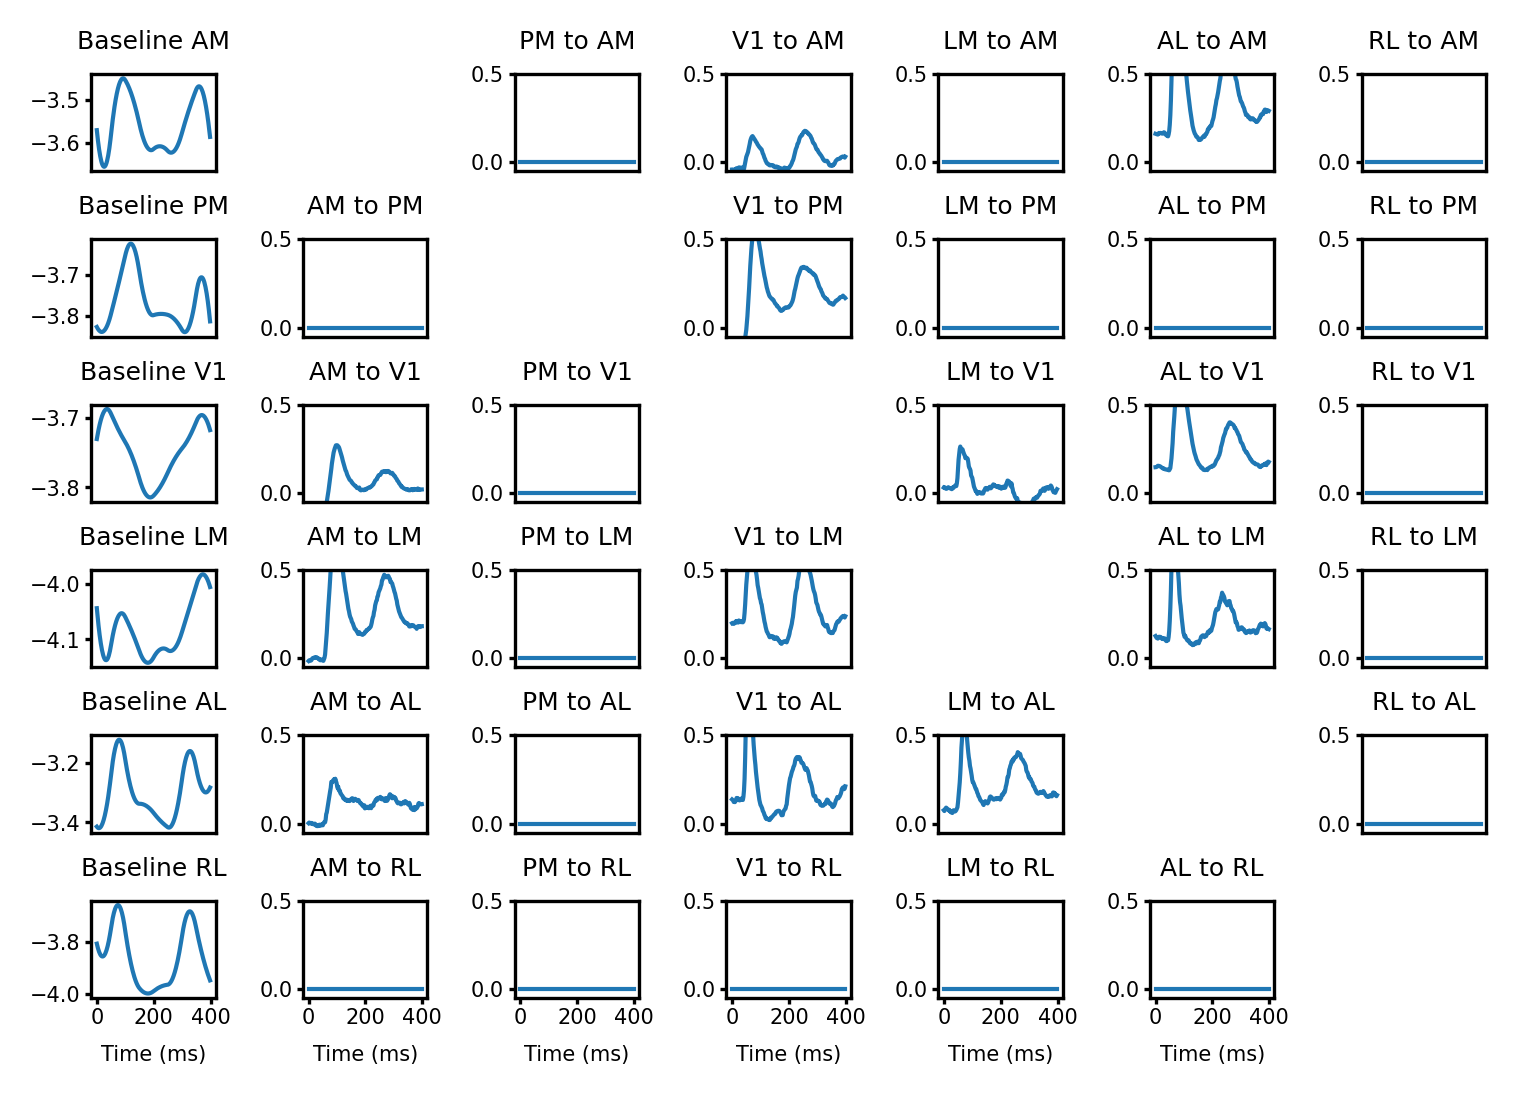

In [184]:
firing_rate_test, sti_mu_test, sti_logvar_test, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    manual_batches=[batch],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=False,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=False,
    return_spike_trains=True,
)

### Plot mean coupling output from area i (or baseline) to area j, averaged across trials and neurons
plot_session = str(757216464)

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
utils.use_pdf_plot()

area_names = list(utils.PROBE_CORRESPONDING.values())
xxx = 2*np.arange(trainer.model.coupling_outputs[0][1].shape[2])

fig = plt.figure(figsize=(6, 4), dpi=300)
outer = GridSpec(6, 7, figure=fig, wspace=0.7, hspace=0.7)
axes = np.empty((6, 7), dtype=object)
for i in range(6):
    for j in range(7):
        if (i, j) not in [] and i != j-1:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])
for i in range(6):
    for j in range(7):
        if i == j-1:
            continue
        if j == 0:
            # Plot baseline
            neuron_start = trainer.model.accnneuron_dict[plot_session][i]
            neuron_end = trainer.model.accnneuron_dict[plot_session][i+1]
            outputs = trainer.model.firing_rates_stimulus[:,neuron_start:neuron_end,:].detach().cpu().numpy()
            neuron_selected = np.argsort(outputs.mean(axis=(0,2)))[-10:]
            outputs = outputs[:,neuron_selected,:]
            axes[i,j].plot(xxx, outputs.mean(axis=(0,1)))
            axes[i,j].set_title(f'Baseline {area_names[i]}')
            # axes[i,j].set_xlabel('Time (ms)')
            # axes[i,j].set_ylabel('log firing rate')
            # axes[i,j].set_ylim(-5, 0)
            # axes[i,j].set_xticks([0, 200, 400])
            
        else:
            if j-1 != i:
                # Plot cross-area coupling
                outputs = trainer.model.coupling_outputs[j-1][i].detach().cpu().numpy()[:,:,:]
                # Find top 10 neurons with largest coupling outputs
                neuron_selected = np.argsort(outputs.mean(axis=(0,2)))[-10:]
                outputs = outputs[:,neuron_selected,:]
                axes[i,j].plot(xxx, outputs.mean(axis=(0,1)))
                axes[i,j].set_title(f'{area_names[j-1]} to {area_names[i]}')
                # axes[i,j].set_xlabel('Time (ms)')
                # axes[i,j].set_ylabel('log firing rate')
                axes[i,j].set_ylim(-0.05, 0.5)
                # axes[i,j].set_xticks([0, 200, 400])
                # axes[i,j].set_yticks([-2, 0, 2])
        if i == 5:
            axes[i,j].set_xticks([0, 200, 400])
            axes[i,j].set_xlabel('Time (ms)')
        else:
            axes[i,j].set_xticks([])
            
# plt.savefig('Figure/Figure5_real_data_coupling_output.pdf', bbox_inches='tight', dpi=300)


In [191]:
batch['neuron_id']

array([951814834, 951814827, 951814874, 951814839, 951814898, 951814932,
       951814919, 951814995, 951814924, 951815001, 951814988, 951815029,
       951815063, 951815055, 951815071, 951815091, 951815099, 951815126,
       951815173, 951815142, 951816048, 951815207, 951815200, 951815269,
       951815239, 951815223, 951815231, 951815287, 951815250, 951816078,
       951815340, 951815333, 951815324, 951815317, 951815307, 951815297,
       951815403, 951815393, 951815377, 951815361, 951816084, 951815453,
       951815384, 951815487, 951815469, 951815536, 951815520, 951815623,
       951815588, 951815570, 951816113, 951815636, 951815629, 951815663,
       951815729, 951815699, 951815681, 951815750, 951815838, 951815816,
       951815808, 951815789, 951815865, 951815898, 951807199, 951807175,
       951807228, 951807254, 951807245, 951807236, 951807209, 951808234,
       951808366, 951807290, 951807283, 951807276, 951807333, 951807325,
       951807310, 951807373, 951808240, 951807357, 